# Exploratory Data Analysis For Predicting Customer Lifetime Value

## Introduction

We are given a parquet file that contains users and some interaction data of users with a mobile application. The contains each user's first year revenue. The objective is to predict this first year revenue for the related users on examining and modelling the information about the user-app interaction during their first 15-day usage of this mobile application.

A good solution to this problem is quite important for companies who really aim to understand users behavior to develop strategies for the different range of users. However, this problem is quite challenging so it deserves a long academic study on it. We try building a XGBoost model by using best practices as much as possible.

## Data Overview

Before getting our feet wet, let us take some fundamental steps about our data. We start creating a Pandas data frame object tp store ltv data. Then we try to figure out what we can do with what we have in hour hands.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Setting the formatting for the readability and details
pd.options.display.float_format = "{:,.3f}".format

In [2]:
df_raw = pd.read_parquet("../data/raw/ltv_prediction_raw.parquet")

print(f"The shape of df_raw is {df_raw.shape}\n")
print(f"df_raw contains some null values: {df_raw.isna().values.any()}")
print(f"df_raw contains some duplicated rows: {df_raw.duplicated().values.any()}\n")

df_raw.info()

The shape of df_raw is (6984129, 9)

df_raw contains some null values: True
df_raw contains some duplicated rows: True

<class 'pandas.DataFrame'>
RangeIndex: 6984129 entries, 0 to 6984128
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user_id             str    
 1   first_event_date    str    
 2   operating_system    str    
 3   country             str    
 4   event_name          str    
 5   event_time          str    
 6   event_date          str    
 7   revenue             float64
 8   first_year_revenue  float64
dtypes: float64(2), str(7)
memory usage: 825.8 MB


In [3]:
df_raw.head()

,user_id,first_event_date,operating_system,country,event_name,event_time,event_date,revenue,first_year_revenue
0,271828,2023-06-29,iOS,AD,paywall,1688053893321,2023-06-29,NaN,0.000
1,271829,2023-08-09,iOS,AD,paywall,1691559504358,2023-08-09,NaN,0.000
2,271830,2023-04-21,iOS,AE,free_trial,1682074694377,2023-04-21,NaN,0.000
3,271831,2023-04-22,iOS,AE,paywall,1682141338714,2023-04-22,NaN,0.000
4,271832,2023-04-22,iOS,AE,paywall,1682191393819,2023-04-22,NaN,0.000


In [4]:
df_raw.tail()

,user_id,first_event_date,operating_system,country,event_name,event_time,event_date,revenue,first_year_revenue
6984124,2471717,2023-08-04,iOS,ZW,paywall,1691442431452,2023-08-07,NaN,0.000
6984125,2083163,2023-08-10,iOS,ZW,paywall,1691637797610,2023-08-10,NaN,0.000
6984126,1502524,2023-08-13,iOS,ZW,paywall,1691911810441,2023-08-13,NaN,0.000
6984127,537344,2023-08-14,iOS,ZW,paywall,1692047184577,2023-08-14,NaN,0.000
6984128,380521,2023-08-08,iOS,ZW,paywall,1692078553341,2023-08-15,NaN,0.000


In [5]:
df_raw.isna().sum()

user_id                     0
first_event_date            0
operating_system            0
country                  4103
event_name                  0
event_time                  0
event_date                  0
revenue               6818187
first_year_revenue          0
dtype: int64

After dropping the duplicates, fill null values with 0 in the revenue column. The null values in the country column would be handled too, afterwards it will be seen every country has different user groups. Also, change the `str` format to `datetime` for the relevant columns.

In [6]:
df_raw.drop_duplicates(inplace=True)

df_raw.dropna(subset=["country"], inplace=True)
df_raw["revenue"] = df_raw["revenue"].fillna(0)

df_raw["event_date"] = pd.to_datetime(df_raw["event_date"])
df_raw["first_event_date"] = pd.to_datetime(df_raw["first_event_date"])

In [7]:
df_raw.isna().sum()

user_id               0
first_event_date      0
operating_system      0
country               0
event_name            0
event_time            0
event_date            0
revenue               0
first_year_revenue    0
dtype: int64

Check the number of users have negative and tiny values over `first_year_revenue`.

In [8]:
negatives = df_raw[df_raw.first_year_revenue < 0]
tiny = df_raw[(df_raw.first_year_revenue > 0) & (df_raw.first_year_revenue < 0.001)]

print(f"Number of users with negative first year revenue: {negatives.user_id.nunique()}")
print(f"Sum of negative first year revenues: {negatives.first_year_revenue.sum()}\n")

print(f"Number of users with tiny first year revenue: {tiny.user_id.nunique()}")
print(f"Sum of tiny first year revenues: {tiny.first_year_revenue.sum()}")

Number of users with negative first year revenue: 44
Sum of negative first year revenues: -1198.5179

Number of users with tiny first year revenue: 1
Sum of tiny first year revenues: 3.307354390358341e-15


Some negligible number of users have negative `first_year_revenue`, and there is an outlier with super tiny amount of revenue. Both negative and tiny valued rows over `first_year_revenue` should be dropped.

In [9]:
len_before = len(df_raw)
df_raw = df_raw[(df_raw.first_year_revenue == 0) | (df_raw.first_year_revenue > 0.001)]

print(f"{len_before - len(df_raw)} number of rows are dropped.")

158 number of rows are dropped.


Going further is appreciated now, and let's view the distribution of `first_year_revenue`. Additionally, the distribution of non-zero `first-year-revenues` is considered.

Let's create `users_ltv` table that contains fixed values like `operating_system`, `country` and `first-year-revenues`.

In [10]:
users_ltv = (
    df_raw.groupby(["user_id", "operating_system", "country"], as_index=False)
    .agg(first_year_revenue=("first_year_revenue", "first"))
)

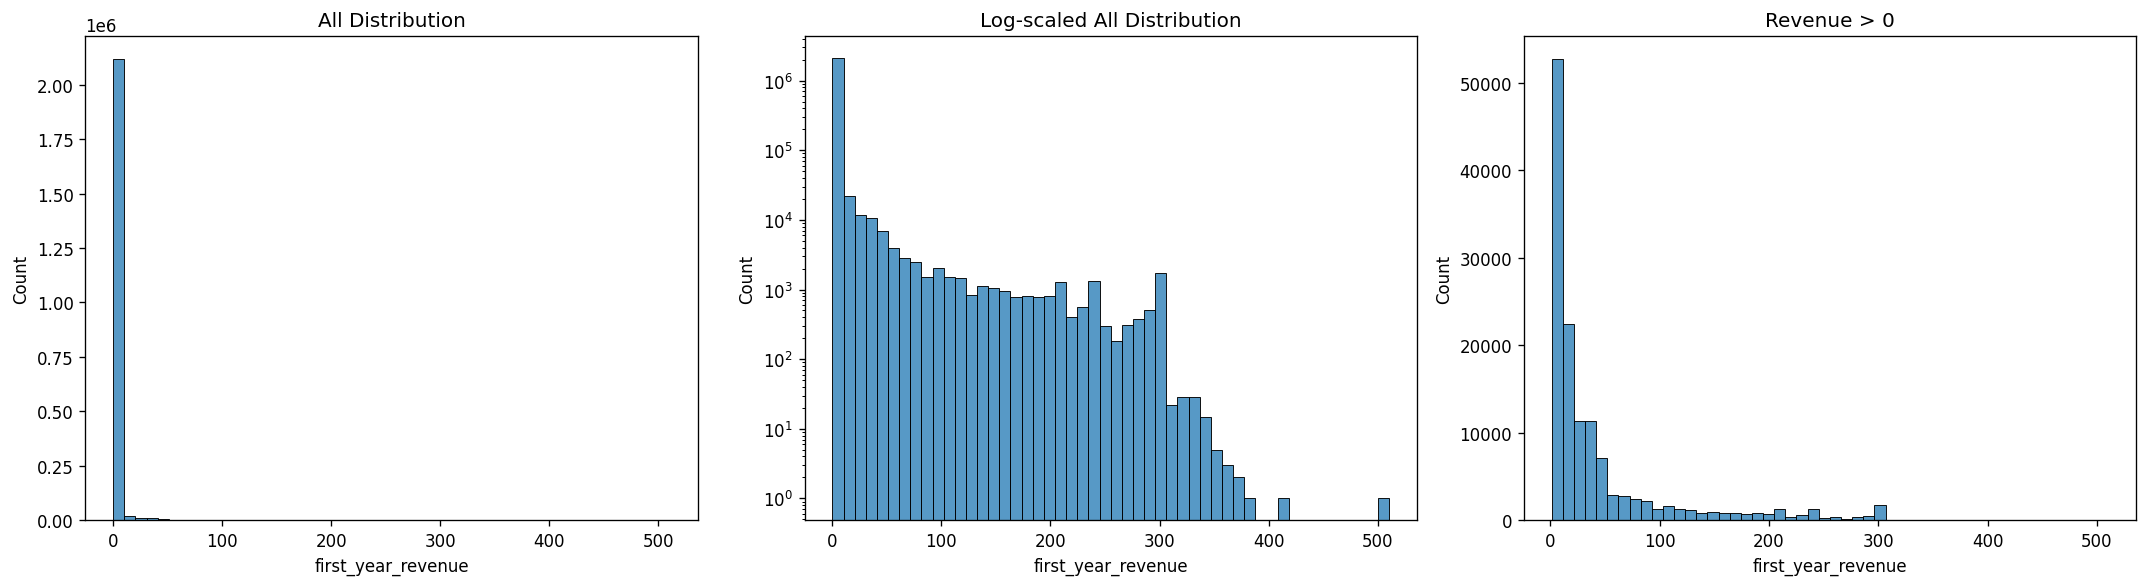

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=120)

sns.histplot(users_ltv, x="first_year_revenue", bins=50, ax=axes[0])
axes[0].set_title("All Distribution")

sns.histplot(users_ltv, x="first_year_revenue", bins=50, ax=axes[1])
axes[1].set_yscale("log")
axes[1].set_title("Log-scaled All Distribution")

sns.histplot(users_ltv[users_ltv.first_year_revenue > 0], x="first_year_revenue", bins=50, ax=axes[2])
axes[2].set_title("Revenue > 0")


plt.tight_layout()
plt.show()

We see the vast majority of users do not contribute to the income. Hence, LTV is highly-skewed, meaning minority of users are responsible for the company income. Please consider the plot below to see more about this relationship between LTV and users.

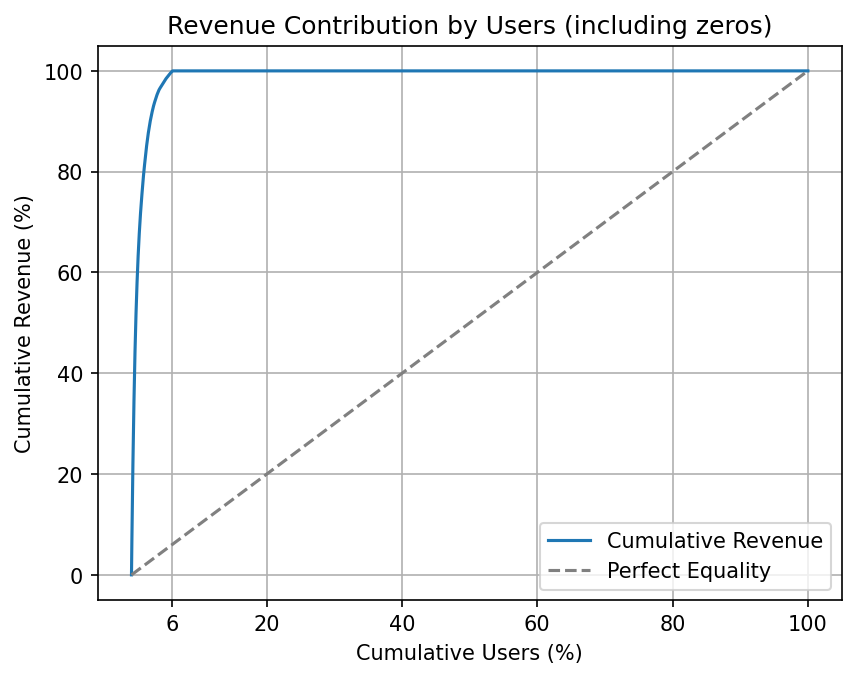

In [12]:
users_ltv_cum = users_ltv.copy()  # include zero revenue users
users_ltv_cum = users_ltv_cum.sort_values("first_year_revenue", ascending=False)
users_ltv_cum["cum_revenue"] = users_ltv_cum.first_year_revenue.cumsum()

total_revenue = users_ltv_cum.first_year_revenue.sum()

users_ltv_cum["cum_revenue_pct"] = users_ltv_cum["cum_revenue"] / total_revenue
users_ltv_cum["user_pct"] = np.arange(1, len(users_ltv_cum)+1) / len(users_ltv_cum)

plt.figure(dpi=150)
plt.plot(users_ltv_cum["user_pct"]*100, users_ltv_cum["cum_revenue_pct"]*100, label="Cumulative Revenue")
plt.plot([0,100],[0,100], "--", color="gray", label="Perfect Equality")
plt.xlabel("Cumulative Users (%)")
plt.ylabel("Cumulative Revenue (%)")
plt.title("Revenue Contribution by Users (including zeros)")
plt.legend()
plt.grid(True)
plt.xticks(np.concatenate([[6], np.arange(20, 101, 20)]))
plt.show()


About %6 of the users complete the whole income. We need some good features that eliminates this %94 of users, so the company can focus on this %6 percent to remain their income.

Next, we can do some feature engineering to eliminate some of them, detect which ones are important. We will do some box-plots on `operating_system`, `country`, `event_name`, and then expand our data with the retention metrics.

## Feature Engineering

The most suspicious feature seems to be `operating_system`. The code under the operating system section clearly indicates we have one type of `operating_system`. Hence, this feature is more about device types, phone or tablet. Having more type of data in this column like android could change the picture. 

### Operating System

In [13]:
df_raw.operating_system.value_counts()

operating_system
iOS       6722568
ios        184372
iPadOS      69589
Name: count, dtype: int64

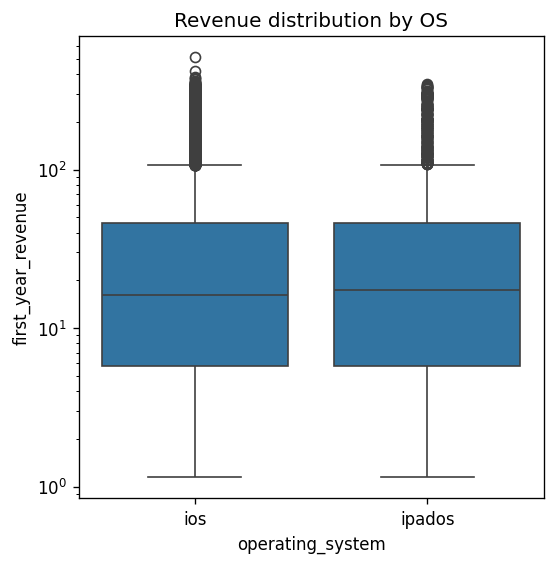

In [14]:
users_ltv.operating_system = users_ltv.operating_system.str.lower()

plt.figure(figsize=(5,5), dpi=120)
sns.boxplot(
    data=users_ltv[users_ltv.first_year_revenue > 0],
    x="operating_system",
    y="first_year_revenue"
)

plt.yscale("log")
plt.title("Revenue distribution by OS")
plt.show()

For the box-plot above, the case `first_year_revenue = 0` is omitted since it only show outliers as boxes are dominated by the number of 0's. Therefore, we only check this box plot for the case `first_year_revenue` is non-zero, however, they are almost identical as they should be.

How about the countries? They make any difference at evaluating contributing users, or how much they contribute? 

### Country

A distribution of countries would be useful, it could help to be sure that users from different countries are subject to somehow reasonable amount of `first_year_revenue`.

In [15]:
print(users_ltv[["country"]].value_counts(normalize=True))

country
US        0.174
IN        0.066
GB        0.064
BR        0.063
DE        0.041
           ... 
BL        0.000
SY        0.000
ER        0.000
IO        0.000
NU        0.000
Name: proportion, Length: 234, dtype: float64


It seems that some countries has no affect on the revenue, however, the main reason for that could still be those countries have much less users than remaining others. So, let's filter out countries with small number of peoples and present under the label 'Other'.

In [16]:
counts = users_ltv["country"].value_counts(normalize=True)
rare_countries = counts[counts < 0.009].index
users_ltv["country_clean"] = users_ltv["country"].replace(rare_countries, "Other")

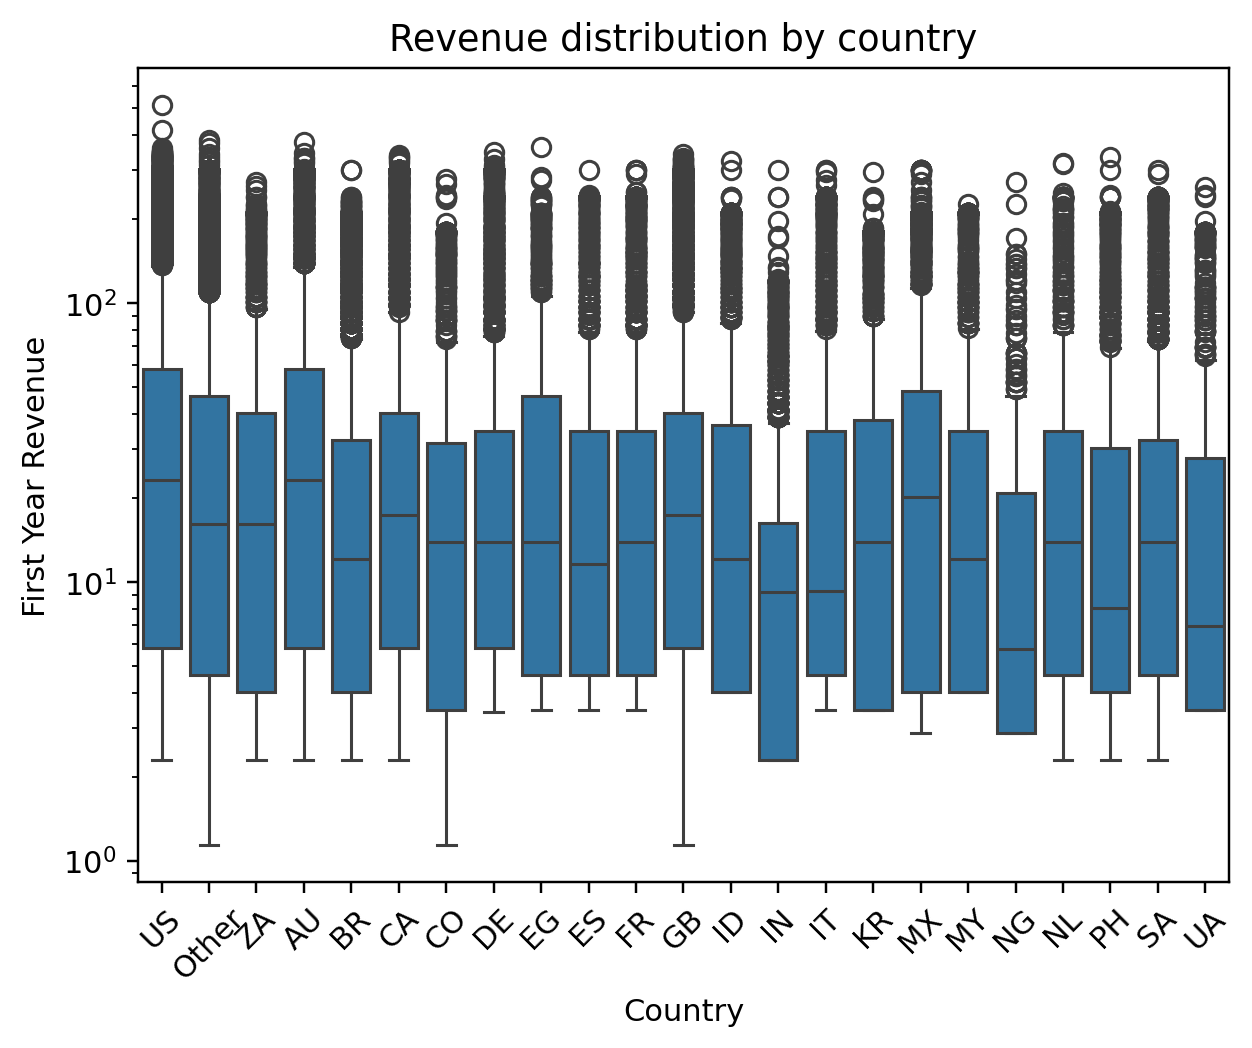

In [17]:
plt.figure(dpi=220)
sns.boxplot(
    data=users_ltv[users_ltv.first_year_revenue != 0],
    x="country_clean",
    y="first_year_revenue"
    
)
plt.yscale("log")  # revenue skewed ise
plt.xticks(rotation=45)
plt.title("Revenue distribution by country")
plt.yscale("log")
plt.xlabel("Country")
plt.ylabel("First Year Revenue")
plt.show()

Again, we only considered the case where `first_year_revenue` is non-zero not to show empty plot. This one says user's country tells something about revenue contribution, though not that strong, the label is worth including for the model because it can be a effective on forecasting non-zero value of the contribution. One-hot encoding cannot be applied on the `country` because of too many options but target-encoding can be a better option not to explode feature space.

### Events

We are at the first important feature, `events`. There are some important events like subscribe that distinct users from the zero contributors, hence, this event is the most important to detect whether the user is a part of the important %6. 

First, observe the event types. Then, make a data frame of `event` types and how much they contribute. 

In [18]:
df_raw["user_id"].sort_values()

1062852    1000000
1062854    1000001
2663619    1000001
1062857    1000002
3021297    1000002
            ...   
1062846     999997
1062848     999998
1450966     999998
4960499     999998
1062851     999999
Name: user_id, Length: 6976529, dtype: str

In [19]:
df_raw.event_name.value_counts()

event_name
paywall           6267659
free_trial         314101
auto_renew_off     228972
subscribe          104078
renewal             59703
refund               2016
Name: count, dtype: int64

In [20]:
event_revenue = (
    df_raw.groupby("event_name", as_index=False)
        .agg(
            total_users=("user_id", "nunique"),
            total_revenue=("revenue", "sum")
        )
)

In [21]:
event_revenue

,event_name,total_users,total_revenue
0,auto_renew_off,227516,0.000
1,free_trial,313516,0.000
2,paywall,2192787,0.000
3,refund,1995,"-10,181.361"
4,renewal,57115,"296,813.360"
5,subscribe,103740,"762,942.405"


Here, renewal and subscribe are two events directly contribute to the `total_revenue`. The first three events have no cost so their `total_revenue` is 0.

Next, we are going to do one-hot encoding of `event_name` for each user. We are aiming to use it for the model too. If the result is not satisfactory, switching to frequency encoding of `event_name` is an alternative choice.

Just before the encoding lets filter our raw data for those whose 15-day experience is available in the dat set.

In [22]:
max_date = df_raw.event_date.max()
cutoff_date = max_date - pd.Timedelta(days=15)

df_15d = df_raw[df_raw.first_event_date <= cutoff_date].copy()
df_15d["days_since_signup"] = (df_15d.event_date - df_15d.first_event_date).dt.days

# Keep only the first 15-day of the users
df_15d = df_15d[(df_15d.days_since_signup).between(0,14)]

In [23]:
df_15d.tail()

,user_id,first_event_date,operating_system,country,event_name,event_time,event_date,revenue,first_year_revenue,days_since_signup
6984124,2471717,2023-08-04,iOS,ZW,paywall,1691442431452,2023-08-07,0.000,0.000,3
6984125,2083163,2023-08-10,iOS,ZW,paywall,1691637797610,2023-08-10,0.000,0.000,0
6984126,1502524,2023-08-13,iOS,ZW,paywall,1691911810441,2023-08-13,0.000,0.000,0
6984127,537344,2023-08-14,iOS,ZW,paywall,1692047184577,2023-08-14,0.000,0.000,0
6984128,380521,2023-08-08,iOS,ZW,paywall,1692078553341,2023-08-15,0.000,0.000,7


As each user holds information there about on which they the specific event occurs since users signed up the application, it is much easier to create restrict data to the users have the 15-day data, and create new columns to present on which days the users were active.

In [24]:
users_event_encoded = (
    df_15d.groupby(["user_id","event_name"], as_index=False)
        .size()
        .pivot(index="user_id", columns="event_name", values="size")
        .fillna(0)
        .gt(0)  # Evaluate whether the value is zero or not.
        .astype(int)
        .reset_index()
)

# subscribe ve renewal interaction
users_event_encoded['subscribe_renewal'] = (
    users_event_encoded['subscribe'] & users_event_encoded['renewal']
).astype(int)

# paywall ve refund interaction
users_event_encoded['paywall_refund'] = (
    users_event_encoded['paywall'] & users_event_encoded['refund']
).astype(int)

# Merge with first_year_revenue info
users_event_encoded = users_event_encoded.merge(
    df_15d[["user_id","first_year_revenue"]].drop_duplicates("user_id"),
    on="user_id", how="left"
)

users_event_encoded.sample(10)

,user_id,auto_renew_off,free_trial,paywall,refund,renewal,subscribe,subscribe_renewal,paywall_refund,first_year_revenue
884633,1885518,0,0,1,0,0,0,0,0,0.000
1503406,304979,0,0,1,0,0,0,0,0,0.000
1135175,2136302,0,0,1,0,0,0,0,0,0.000
195130,1195316,0,1,0,0,1,1,1,0,40.432
1590236,391858,0,0,1,0,0,0,0,0,0.000
2177397,979595,0,0,1,0,0,0,0,0,0.000
1453562,2454985,0,0,1,0,0,0,0,0,0.000
1064040,2065099,0,0,1,0,0,0,0,0,0.000
1891061,692975,0,1,1,0,1,1,1,0,4.601
1917373,719305,0,0,1,0,0,0,0,0,0.000


Besides the encoded user data, it could be helpful to know how many times these events occur. To test this frequency information in the model, lets calculate the frequencies of the events.

In [25]:
users_event_freq = (
    df_15d.groupby(["user_id","event_name"], as_index=False)
        .size()
        .pivot(index="user_id", columns="event_name", values="size")
        .fillna(0)
        .astype(int)
)

users_event_freq.columns = [column_name + "_freq" for column_name in users_event_freq.columns]
users_event_freq.reset_index(inplace=True)

users_event_freq.sample(10)

,user_id,auto_renew_off_freq,free_trial_freq,paywall_freq,refund_freq,renewal_freq,subscribe_freq
352227,1352557,0,0,2,0,0,0
403718,1404104,0,0,1,0,0,0
373641,1373995,0,0,1,0,0,0
933287,1934224,0,0,2,0,0,0
42695,1042736,0,0,3,0,0,0
2019760,821804,0,0,5,0,0,0
1590133,391755,0,0,2,0,0,0
832825,1833660,0,0,1,0,0,0
1465529,2466961,0,0,1,0,0,0
1395891,2397254,0,0,1,0,0,0


In [26]:
users_event_freq.describe()

,auto_renew_off_freq,free_trial_freq,paywall_freq,refund_freq,renewal_freq,subscribe_freq
count,"2,197,780.000","2,197,780.000","2,197,780.000","2,197,780.000","2,197,780.000","2,197,780.000"
mean,0.104,0.143,2.843,0.001,0.027,0.047
std,0.307,0.351,5.115,0.030,0.169,0.213
min,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,1.000,0.000,0.000,0.000
50%,0.000,0.000,1.000,0.000,0.000,0.000
75%,0.000,0.000,3.000,0.000,0.000,0.000
max,6.000,3.000,533.000,2.000,4.000,3.000


Lets plot the events to be sure what they actually tells.

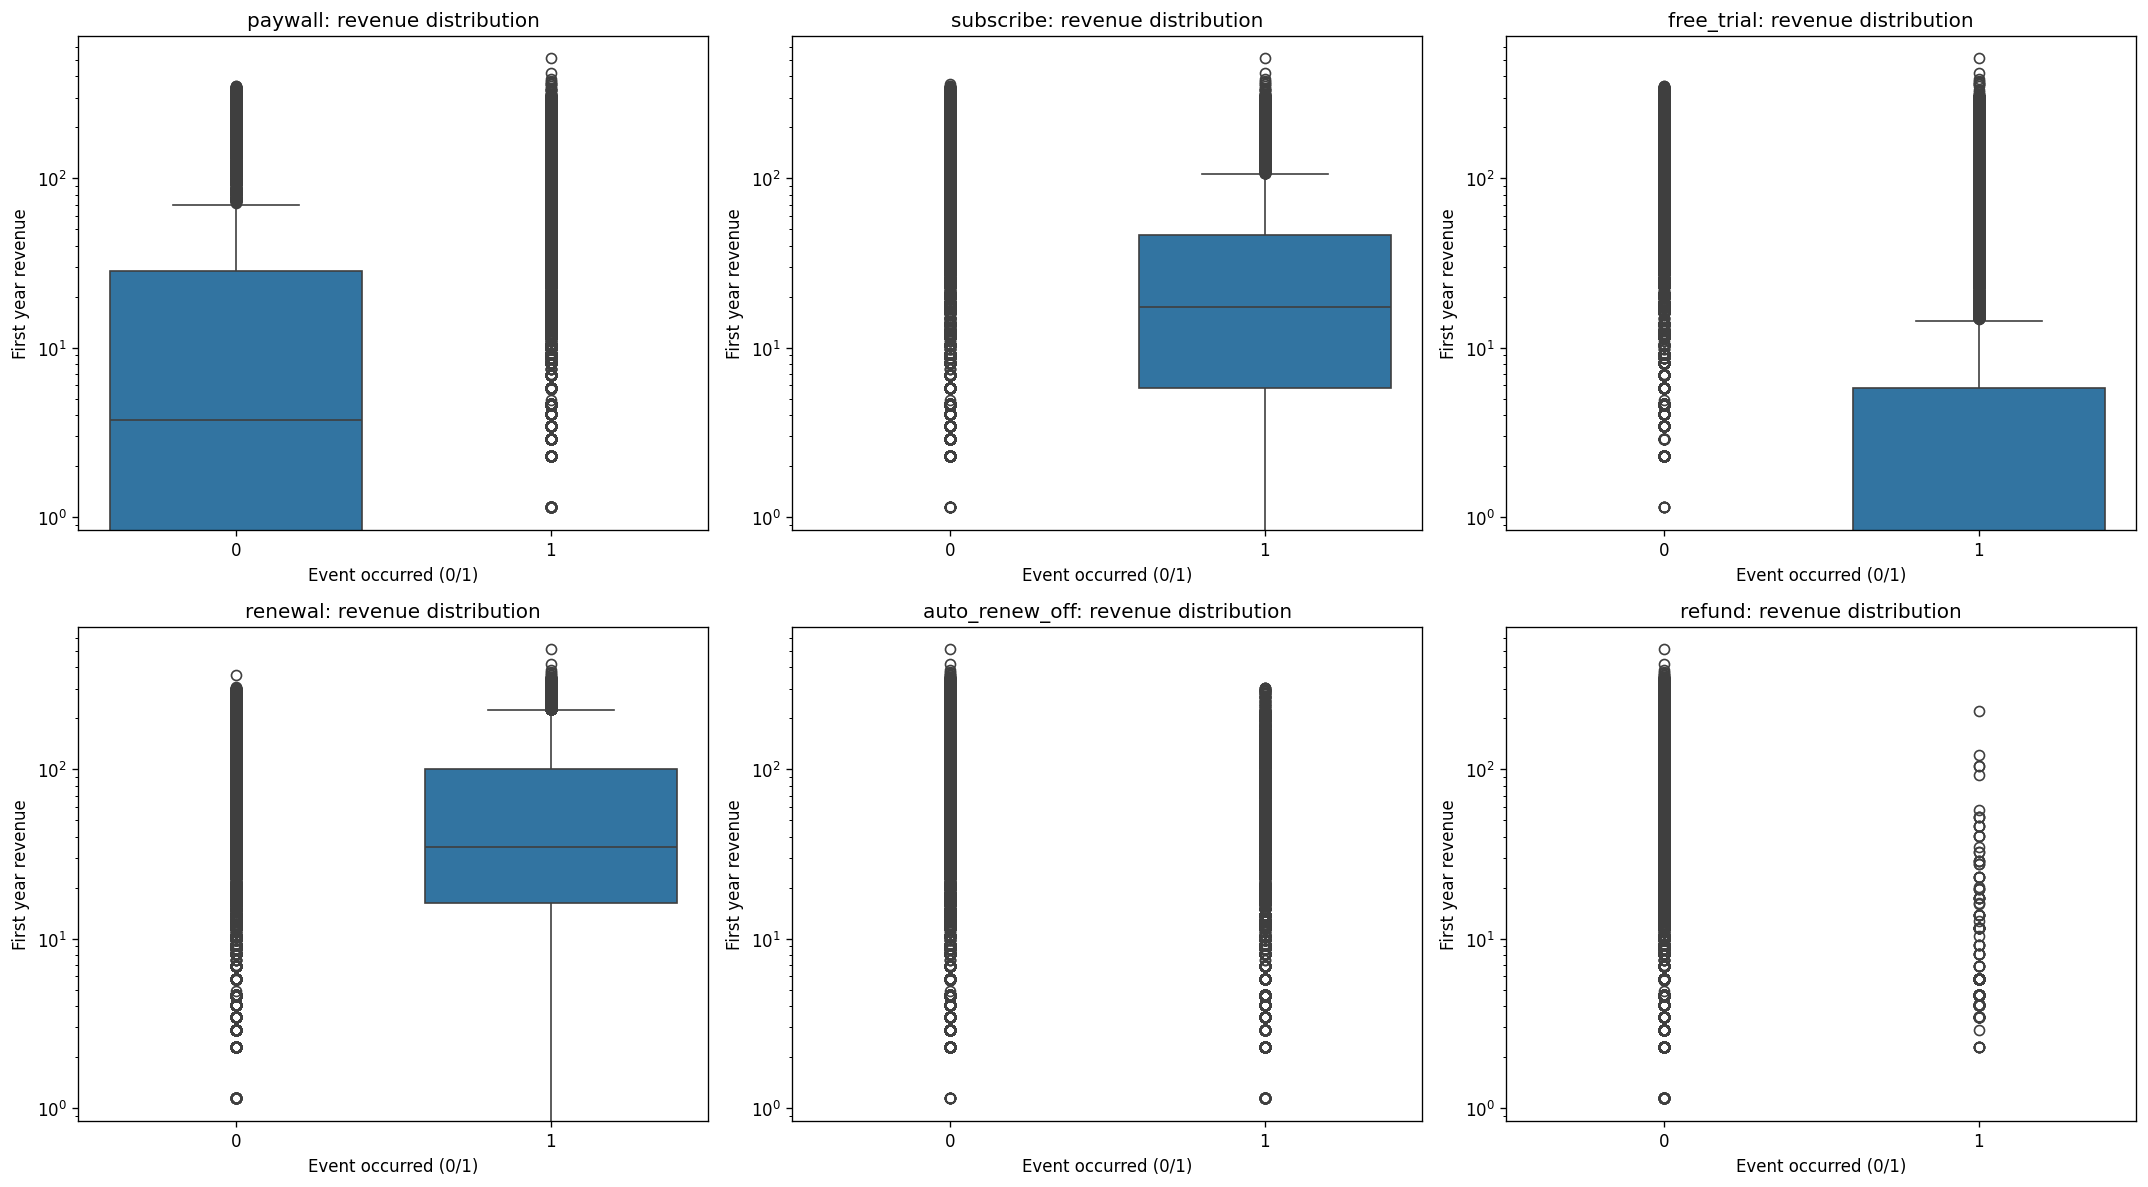

In [27]:
events = ["paywall", "subscribe", "free_trial", "renewal", "auto_renew_off", "refund"]


fig, axes = plt.subplots(2, 3, figsize=(18, 10), dpi=120)
axes = axes.flatten()

for i, event in enumerate(events):
    sns.boxplot(
        data=users_event_encoded,
        x=event,
        y="first_year_revenue",
        ax=axes[i]
    )
    axes[i].set_title(f"{event}: revenue distribution")
    axes[i].set_xlabel("Event occurred (0/1)")
    axes[i].set_ylabel("First year revenue")
    axes[i].set_yscale("log")

plt.tight_layout()
plt.show()

Once again, it is clear that subscribe and renewal are directly related to revenue. In addition to those two, free trial can help to detect the users in the 6%.

Another considerable feature would be the two-week revenue gained from a user. 

In [28]:
users_revenue = df_15d.groupby("user_id", as_index=False).agg(
    two_week_revenue=("revenue", "sum"),
    first_year_revenue=("first_year_revenue", "first")
)

In [29]:
users_revenue

,user_id,two_week_revenue,first_year_revenue
0,1000000,0.000,0.000
1,1000001,0.000,0.000
2,1000002,0.000,0.000
3,1000003,0.000,0.000
4,1000004,46.323,46.323
...,...,...,...
2197775,999995,11.552,300.349
2197776,999996,0.000,0.000
2197777,999997,0.000,0.000
2197778,999998,0.000,0.000


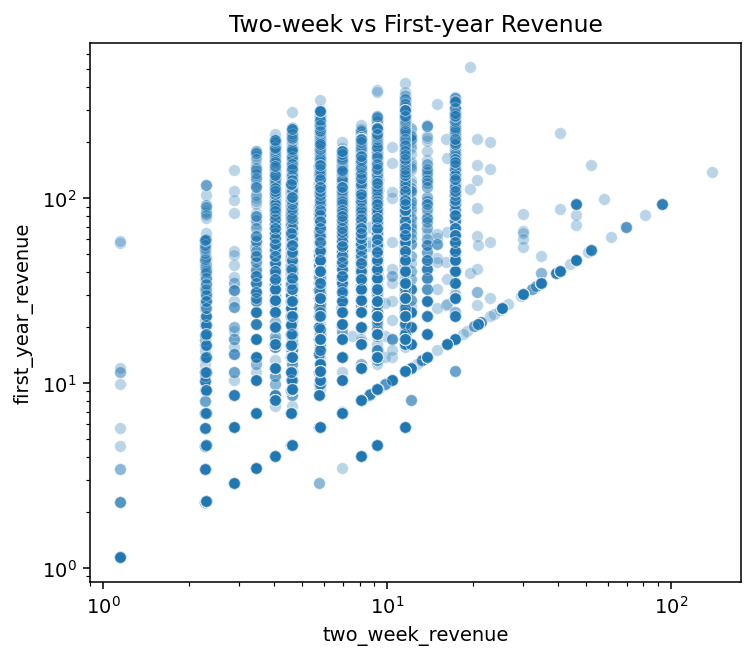

In [30]:
plt.figure(figsize=(6,5), dpi=140)
sns.scatterplot(x='two_week_revenue', y='first_year_revenue', data=users_revenue, alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.title('Two-week vs First-year Revenue')


plt.show()

In [31]:
users_revenue['two_week_revenue'].corr(users_revenue['first_year_revenue'])

np.float64(0.45636185121498135)

The correlation between ```two_week_revenue``` and ```first_year_revenue``` is moderate (about 0.45). So what does this really say? Early spending behavior provides some predictive signal, but it is not sufficient on its own, as users with similar ```two_week_revenue```s can end up with very different annual revenues. Therefore, ```two_week_revenue``` is a useful but not that important feature, however, it might be useful with other features together.

### Model Data

First, we explore on which days the users were active, then group out these active days in five different sections. Smaller group sizes are potential option to make a better model, however, we do this actually to test having all active days information is too much or not. We can go further include all active days with group of active days.

In [32]:
users_active_days = (
    df_15d.groupby(["user_id", "first_event_date", "country", "days_since_signup"])["event_name"]
        .count()
        .unstack(fill_value=0)
        .gt(0)
        .astype(int)
)
users_active_days.drop(columns=[0], inplace=True)
users_active_days.sample(10)

,,days_since_signup,1,2,3,4,5,6,7,8,9,10,11,12,13,14
user_id,first_event_date,country,,,,,,,,,,,,,,
929697,2023-05-28,IT,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2406137,2023-06-19,RU,0,0,0,0,0,0,0,0,0,0,0,0,0,0
907636,2023-05-23,IN,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1937211,2023-04-21,GB,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1065972,2023-04-22,GB,0,0,0,0,0,0,0,0,0,0,0,0,0,0
648186,2023-07-23,SA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1575444,2023-08-17,IE,0,0,0,0,0,0,0,0,0,0,0,0,0,0
579173,2023-05-16,IN,1,1,0,0,0,0,0,0,0,0,1,0,0,0
2223850,2023-06-12,SA,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Below, in addition to the group of active days, 

In [33]:

day_intervals = [(1,2), (3,5), (6,8), (9,11), (12,14)]
features_set = {}

for i, (start, end) in enumerate(day_intervals, 1):
    features_set[f"active_days_{start}_{end}"] = users_active_days.loc[:, start:end].sum(axis=1)
    

features_set["total_active_days_14"] = users_active_days.loc[:, 1:14].sum(axis=1)

def longest_consecutive(row):
    longest_cons = cons = 0
    for val in row:
        if val == 1:
            cons += 1
            longest_cons = max(longest_cons, cons)
        else:
            cons = 0
    return longest_cons


features_set["max_consecutive_active_days_14"] = users_active_days.apply(longest_consecutive, axis=1)


users_active_days.columns = ["day_" + str(col_name) for col_name in users_active_days.columns]
users_active_days.reset_index(inplace=True)
users_active_days.drop(columns=["first_event_date", "country"], inplace=True)

users_engagement = pd.DataFrame(features_set).reset_index()
users_engagement = users_engagement.merge(users_active_days, on="user_id")


In [34]:
users_engagement.sample(10)

,user_id,first_event_date,country,active_days_1_2,active_days_3_5,active_days_6_8,active_days_9_11,active_days_12_14,total_active_days_14,max_consecutive_active_days_14,...,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14
1320323,2321574,2023-06-16,IN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2161261,963330,2023-08-13,BR,0,0,1,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
1333780,2335044,2023-06-18,SA,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
449830,1450226,2023-06-21,BR,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1886924,688748,2023-04-25,GB,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
675932,1676557,2023-07-16,US,0,0,1,0,1,2,1,...,0,1,0,0,0,0,0,0,1,0
185290,1185445,2023-07-29,US,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1277736,2278953,2023-04-28,ID,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
665243,1665860,2023-08-01,UZ,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2065068,867045,2023-05-09,US,1,0,0,1,0,2,1,...,0,0,0,0,1,0,0,0,0,0


Lets merge `users_engagement`, `users_event_encoded` and `users_revenue` data frames, and replace outliers with a reasonable percentile to finalize our input for the model.

In [35]:
users_model_input = users_engagement.merge(users_event_encoded, on="user_id")
users_model_input = users_model_input.merge(users_event_freq, on="user_id")
users_model_input = users_model_input.merge(users_revenue[["user_id", "two_week_revenue"]], on="user_id")

users_model_input["first_year_revenue_capped_98"] = np.clip(
    users_model_input["first_year_revenue"], 
    a_min=0,
    a_max=users_model_input["first_year_revenue"].quantile(0.98)
)

users_model_input["first_year_revenue_capped_99"] = np.clip(
    users_model_input["first_year_revenue"], 
    a_min=0,
    a_max=users_model_input["first_year_revenue"].quantile(0.99)
)

Although we capped the ```first_year_revenue```, this approach may limit the models’ ability to capture the true value of top customers. However, during model development, we found that capping these outliers was the only viable option. As shown below, the data is highly skewed, which makes prediction significantly more challenging.

In [36]:
users_model_input["first_year_revenue"].describe(percentiles=[0.93, 0.94, 0.95,0.96,0.97,0.98,0.99])

count   2,197,888.000
mean            2.658
std            19.068
min             0.000
93%             0.000
94%             3.459
95%             5.776
96%             8.076
97%            17.328
98%            34.738
99%            76.726
max           510.336
Name: first_year_revenue, dtype: float64

In [37]:

q97 = users_model_input["first_year_revenue"].quantile(0.97)
q98 = users_model_input["first_year_revenue"].quantile(0.98)
q99 = users_model_input["first_year_revenue"].quantile(0.99)

total_revenue = users_model_input["first_year_revenue"].sum()

# top %3 (97–100%)
top3 = users_model_input.loc[users_model_input["first_year_revenue"] > q97, "first_year_revenue"].sum() / total_revenue

# top %2 (98–100%)
top2 = users_model_input.loc[users_model_input["first_year_revenue"] > q98, "first_year_revenue"].sum() / total_revenue

# top %1 (99–100%)
top1 = users_model_input.loc[users_model_input["first_year_revenue"] > q99, "first_year_revenue"].sum() / total_revenue

print("Top %3 contribution:", round(top3*100,2), "%")
print("Top %2 contribution:", round(top2*100,2), "%")
print("Top %1 contribution:", round(top1*100,2), "%")


Top %3 contribution: 90.44 %
Top %2 contribution: 80.33 %
Top %1 contribution: 63.58 %


In [38]:
(
    users_model_input
    .sort_values("first_year_revenue", ascending=False)
    [["first_year_revenue", "first_year_revenue_capped_99", "first_year_revenue_capped_98"]]
    .head()
)

,first_year_revenue,first_year_revenue_capped_99,first_year_revenue_capped_98
1539979,510.336,76.726,34.738
230739,418.020,76.726,34.738
174166,384.506,76.726,34.738
1854185,376.529,76.726,34.738
1706865,372.954,76.726,34.738


Note that ```first_year_revenue_capped_99``` still contains large values. Applying ```log1p``` to both columns can be an effective way to suppress outliers and stabilize variance.

In [39]:
users_model_input["first_year_revenue_log"] = np.log1p(users_model_input["first_year_revenue"])
users_model_input["first_year_revenue_capped_99_log"] = np.log1p(users_model_input["first_year_revenue_capped_99"])

In [40]:
(
    users_model_input
    .sort_values("first_year_revenue", ascending=False)
    [["first_year_revenue", "first_year_revenue_capped_99", "first_year_revenue_capped_98", "first_year_revenue_log", "first_year_revenue_capped_99_log"]]
    .head()
)


,first_year_revenue,first_year_revenue_capped_99,first_year_revenue_capped_98,first_year_revenue_log,first_year_revenue_capped_99_log
1539979,510.336,76.726,34.738,6.237,4.353
230739,418.020,76.726,34.738,6.038,4.353
174166,384.506,76.726,34.738,5.955,4.353
1854185,376.529,76.726,34.738,5.934,4.353
1706865,372.954,76.726,34.738,5.924,4.353


Now, it looks much better. And, we are ready to train our model. But before, since we will add cohort revenues to the final output, lets visualize the cohort retention.

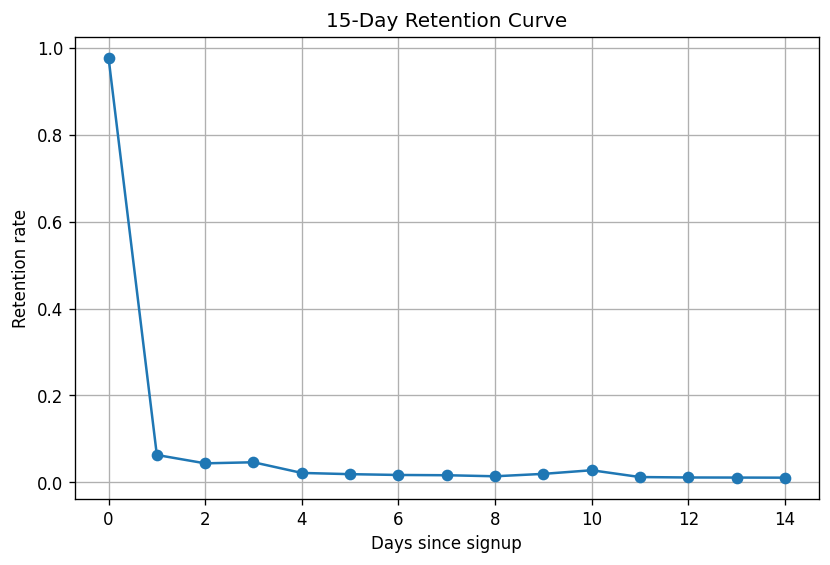

In [41]:
cohort_sizes = df_15d.groupby("first_event_date")["user_id"].nunique()

retention = (
    df_15d.groupby(["first_event_date","days_since_signup"])["user_id"]
          .nunique()
          .unstack(fill_value=0)
          .div(cohort_sizes, axis=0)
)

avg_retention = retention.mean(axis=0)

# Plot
plt.figure(figsize=(8,5), dpi=120)
plt.plot(avg_retention.index, avg_retention.values, marker="o")
plt.title("15-Day Retention Curve")
plt.xlabel("Days since signup")
plt.ylabel("Retention rate")
plt.grid(True)
plt.show()

As it is expected, the most users does not come back after the first installation. 

Here are the all features we collected.

In [42]:
users_model_input.columns

Index(['user_id', 'first_event_date', 'country', 'active_days_1_2',
       'active_days_3_5', 'active_days_6_8', 'active_days_9_11',
       'active_days_12_14', 'total_active_days_14',
       'max_consecutive_active_days_14', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11',
       'day_12', 'day_13', 'day_14', 'auto_renew_off', 'free_trial', 'paywall',
       'refund', 'renewal', 'subscribe', 'subscribe_renewal', 'paywall_refund',
       'first_year_revenue', 'auto_renew_off_freq', 'free_trial_freq',
       'paywall_freq', 'refund_freq', 'renewal_freq', 'subscribe_freq',
       'two_week_revenue', 'first_year_revenue_capped_98',
       'first_year_revenue_capped_99', 'first_year_revenue_log',
       'first_year_revenue_capped_99_log'],
      dtype='str')

Since we will later experiment with different permutations of feature groups during model training, we first examine the correlation matrix of the numerical features before moving to the modeling notebooks.

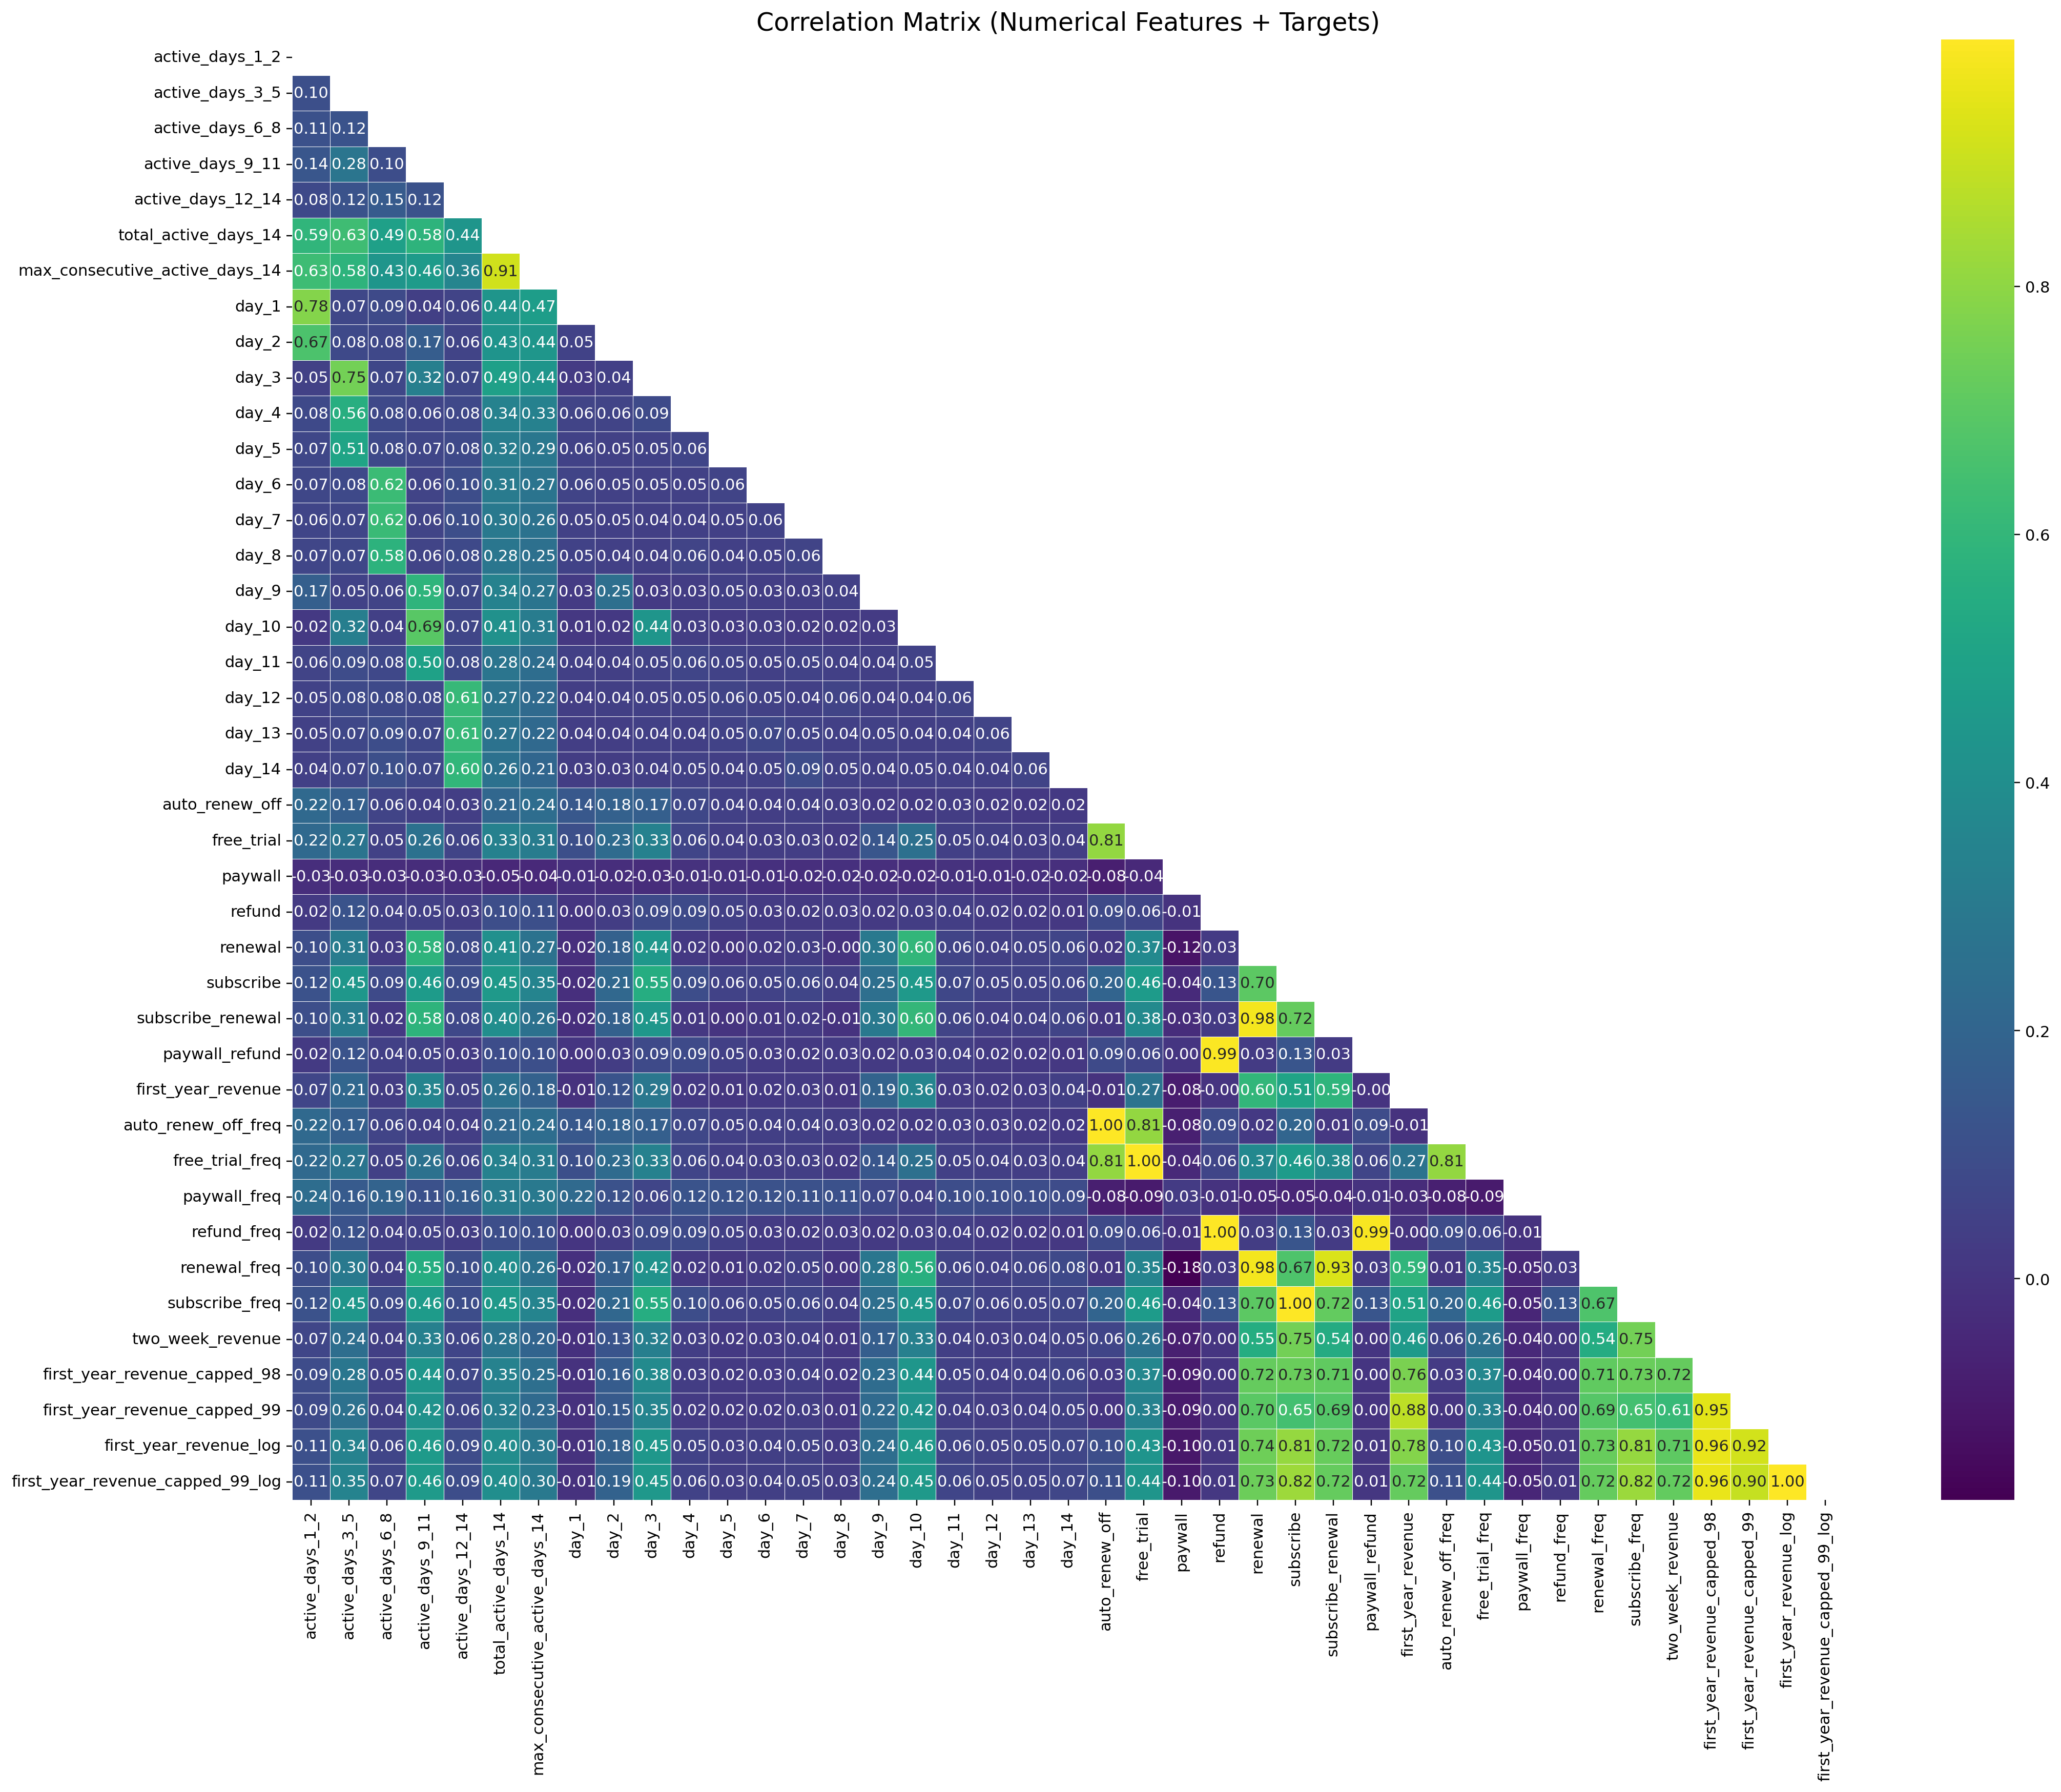

In [43]:
corr = users_model_input.corr(numeric_only=True)

# Upper triangle mask
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20, 16), dpi=220)
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    linewidths=0.3,

)
plt.title("Correlation Matrix (Numerical Features + Targets)", fontsize=16)
plt.tight_layout()
plt.show()

So the values in the correlation matrix are coherent with our previous arguments. While correlation itself is not a strong concern for tree-based models such as XGBoost, the matrix still provides useful insights. It helps us detect redundant features, check for potential data leakage, and understand the relationships between feature groups before experimenting with different permutations in model training. 

The `model.ipynb` file will require the following file.

In [44]:
users_model_input.to_parquet("../data/processed/notebooks_data/users_model_input.parquet", index=False) 

In [45]:
users_model_input.sample(10)

,user_id,first_event_date,country,active_days_1_2,active_days_3_5,active_days_6_8,active_days_9_11,active_days_12_14,total_active_days_14,max_consecutive_active_days_14,...,free_trial_freq,paywall_freq,refund_freq,renewal_freq,subscribe_freq,two_week_revenue,first_year_revenue_capped_98,first_year_revenue_capped_99,first_year_revenue_log,first_year_revenue_capped_99_log
176291,1176440,2023-07-15,ID,0,0,0,0,0,0,0,...,0,4,0,0,0,0.000,0.000,0.000,0.000,0.000
207430,1207607,2023-07-03,IN,0,0,0,0,0,0,0,...,0,2,0,0,0,0.000,0.000,0.000,0.000,0.000
2066462,868439,2023-07-04,US,0,0,0,0,0,0,0,...,0,6,0,0,0,0.000,0.000,0.000,0.000,0.000
585850,1586393,2023-07-06,FR,2,0,0,0,0,2,2,...,0,5,0,0,0,0.000,0.000,0.000,0.000,0.000
946605,1947506,2023-05-25,IT,0,0,0,0,0,0,0,...,0,2,0,0,0,0.000,0.000,0.000,0.000,0.000
115560,1115669,2023-06-30,ZA,0,0,0,0,0,0,0,...,0,2,0,0,0,0.000,0.000,0.000,0.000,0.000
548361,1548861,2023-06-08,KW,0,0,0,0,0,0,0,...,0,2,0,0,0,0.000,0.000,0.000,0.000,0.000
606822,1607387,2023-04-26,AR,0,0,0,0,0,0,0,...,0,1,0,0,0,0.000,0.000,0.000,0.000,0.000
168702,1168854,2023-07-14,UY,1,0,0,1,0,2,1,...,1,2,0,1,1,9.235,18.470,18.470,2.969,2.969
406582,1406938,2023-05-06,FR,0,0,0,0,0,0,0,...,0,1,0,0,0,0.000,0.000,0.000,0.000,0.000
